# Toothpaste setup


In [3]:
import math
import numpy as np
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from Additional_functions import dcpplot, Imp, compute_displacement


We import a defective image to test effectively the quality control. We use SIFT detector to localize accurately the toothpaste in the image. Then we cut the image and compute the difference with the reference one. That means the two images must be as coincident as possible, as that the differences are represented just by the true defects and not by spatial displacement. Let's see if it's enough to test the godness or we have to do some other manipulation. We take as example a picture of a toothpaste with a stain to verify it.

1482


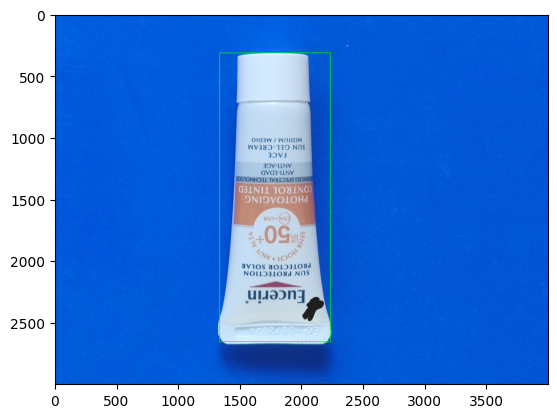

In [5]:
#Reference image
d1, d2, d3, d4 = Imp("Photos/Toothpaste/QueryD.jpg")

#Example image
h1, h2, h3, h4 = Imp("Photos/Toothpaste/D5.jpg")

#Create SIFT
sift = cv2.xfeatures2d.SIFT_create()
FLANN_INDEX_KDTREE = 3
MIN_MATCH_COUNT = 100
kp_query = sift.detect(d2)
kp_query, des_query = sift.compute(d2, kp_query)

image_height, image_width = h1.shape
kp_train = sift.detect(h2)
kp_train, des_train = sift.compute(h2, kp_train)
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 11)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_query,des_train,k=2) #k degree of freedom, number of nearest neighbours we have to evaluate

good = []
for m,n in matches:
    if m.distance < 0.5*n.distance: #0.5 degree of freedom, index of acceptability of a keypoint
        good.append(m)

h,w = d1.shape
print(len(good))
if len(good)>MIN_MATCH_COUNT:
# building the corrspondences arrays of good matches
    src_pts = np.float32([ kp_query[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_train[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
# Using RANSAC to estimate a robust homography. 
# It returns the homography M and a mask for the discarded points

    M1, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 9.0)
        # Projecting the corners into the train image
    
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M1)

    DEN = cv2.polylines(h2,[np.int32(dst)],True, [0,255, 0],3, cv2.LINE_AA)

#dcpplot(h4, DEN, '0010', False, False, 1)
#ddr3 = cv2.rotate(dd3, cv2.ROTATE_180)
plt.imshow(DEN)
plt.show()

Now find the defects, let's try by computing the differences between the query_image and the toothpaste found by the sift descriptor

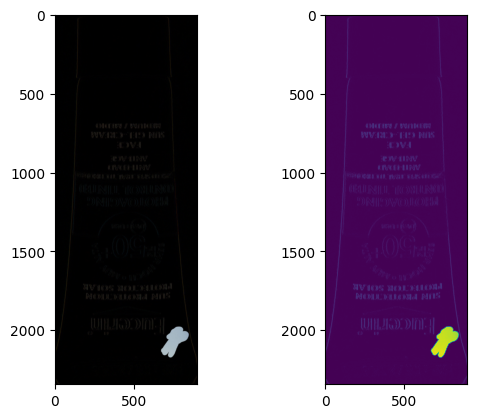

In [6]:
dst = np.int32(dst.reshape(4,2))

basex = dst[0,0]
basey = dst[0,1]
cut_img = h4[basey:basey+h,basex:basex+w]

diff1 = cv2.absdiff(cut_img, d4)
gray_diff1= cv2.cvtColor(diff1, cv2.COLOR_RGB2GRAY)

plt.figure()
plt.subplot(1,2,1)
#colored difference (The more is black the less difference there is)
plt.imshow(diff1)
#Grayscale difference (I keep it purple and yellow because it helps me to understand better)
plt.subplot(1,2,2)
plt.imshow(gray_diff1)

plt.show()

We note that there's a huge difference in the zone where there's the defect (low right) and some other differences elsewhere due to non perfect alignment between the two pictures. Our goal is to filter those fake differences that do not constitute defects.
# Filter differences
Several things can be deployed to filter it, but they must be as general as possible in order to work also with other images that could have other kind of defects. Start by trying to match as much as possible the query image and the toothpaste found by the SIFT descriptor

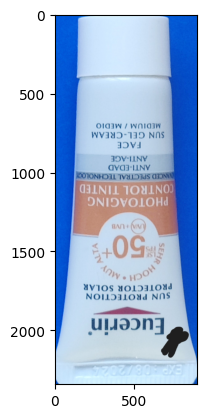

In [7]:
parallelogram_vertices = np.array([[dst[0,0], dst[0,1]], [dst[1,0], dst[1,1]], [dst[2,0], dst[2,1]], [dst[3,0], dst[3,1]]], dtype=np.float32)

h = np.int32((dst[1,1]-dst[3,1]+dst[2,1]-dst[0,1])/2)
w = np.int32((-dst[1,0]-dst[0,0]+dst[2,0]+dst[3,0])/2)
# Define the vertices of the destination rectangle
rectangle_vertices = np.array([[0, 0], [0, h], [w, h], [w,0]], dtype=np.float32)

# Calculate the perspective transformation matrix
perspective_matrix = cv2.getPerspectiveTransform(parallelogram_vertices, rectangle_vertices)

# Apply the perspective transformation
warped_image = cv2.warpPerspective(h4, perspective_matrix, (w,h))

plt.imshow(warped_image)
plt.show()


There's a problem: the warped image hasn't the size of the query image, we have to reshape it but trying to keep unchanged the proportions.

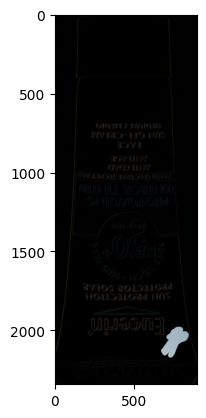

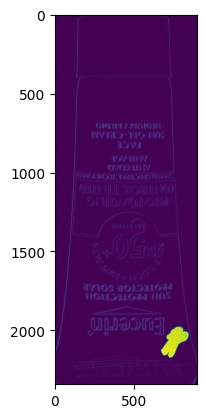

In [8]:

image_resized = cv2.resize(d4, (warped_image.shape[1], warped_image.shape[0]), interpolation=cv2.INTER_AREA)
#Now compute the difference
diff = cv2.absdiff(warped_image, image_resized)
#And the gray one
gray_diff = cv2.cvtColor(diff, cv2.COLOR_RGB2GRAY)
binary_diff = cv2.threshold(gray_diff, 50, 255, cv2.THRESH_BINARY)[1]
plt.imshow(diff)
plt.show()
plt.imshow(gray_diff)
plt.show()


In this case (image D5) not much has changed because they were almost matching, but for other image the previous operation can be very useful, especially if the toothpaste in the image is not perfectly straight. We note that there are still left some edges detected as difference but with a lower intensity with respect to the real defect. Done the alignment, let's do the effective filtering that can be decomposed in three operation:
1. Threshold the differences: those that are too small in terms of numerical values (the gray part in the colored difference were almost all borders for example) are excluded. They can be due to light changing for example, and they, in general, are not the kind of difference we want to classify as defect. This operation both cut out the little differences and give a binary output that we can't think as *difference pixel - not difference pixel*
2. Remove the borders from the differences: we basically exclude all the edges from the difference. With a binarized image is straightforward -> create a mask with the edges computed and then remove it on the image by simply subtracting (255 - 255 = 0 -> not a difference) 
3. open the image: on a thresholded image we can provide an opening operation and cut out all the "non beloging to a region" differences

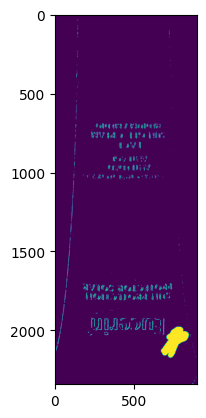

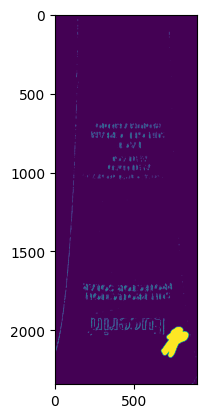

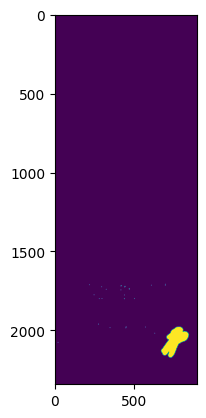

In [9]:
#We have to provide, of course, a binary thresh to cut out all the differences that are not so different
binary_diff = cv2.threshold(gray_diff, 30, 255, cv2.THRESH_BINARY)[1]
plt.imshow(binary_diff)
plt.show()

#Compute the edges
img_edge = cv2.Canny(warped_image, 100, 40, apertureSize = 3)
#and exclude them from the difference
masked_diff = binary_diff - img_edge
plt.imshow(masked_diff)
plt.show()

#And finally on the binarized image provide the opening with a small (3x3) kernel

#KErnel definition
size_k = 3
kernel = np.zeros((size_k, size_k))
kernel[:] = 1
#Opening
opened_diff = cv2.morphologyEx(masked_diff, cv2.MORPH_OPEN, kernel)

plt.imshow(opened_diff)
plt.show()

It remains, highlighted in yellow, just the part of the toothpaste that represents a defect and the other part is basically excluded.

# Classification of the image
We manage to filter almost all the pixels that do not represent a true difference. The left yellow one are definitely classified as difference. Now we use those pixels to classify the image as *good-defectful*. If the percentage of *difference pixel* overcome what we define as acceptability threshold we classify the product as defectful

In [10]:
#Threshold
acceptability = 0.005 #The 99.5% of the image should have non defects

#Height and weight of the image that will be used to compute the area -> total number of pixel
dh, dw = np.shape(opened_diff)
area = dh*dw

difference_pixel = np.count_nonzero(opened_diff)
print(difference_pixel)

ratio = difference_pixel/area

if ratio > acceptability:
    print("The product is defectful")
else:
    print("The product is OK")

17683
The product is defectful


# Orientation

We analyze two simple cases: 
1. The case in which the toothpaste is flipped upside down, so with  the cap towards up. It's treated as the flipped tissue, see it, with the values got from the homography
2. The case in which is turned front-back: in that case, the match with the homography is not found. To differentiate it from the case where there's no product we can simply binarize the image and check for a proper number of "whites" or to bound him we can classify it as the second biggest connected component as it should be

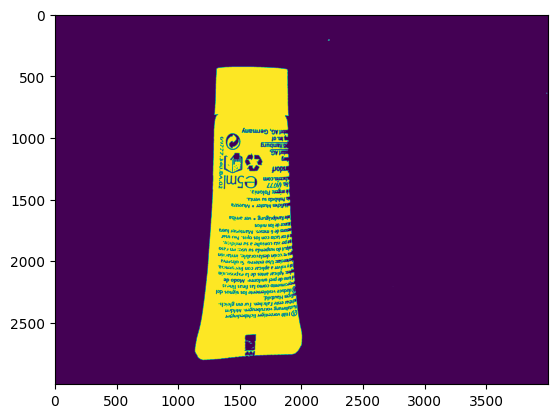

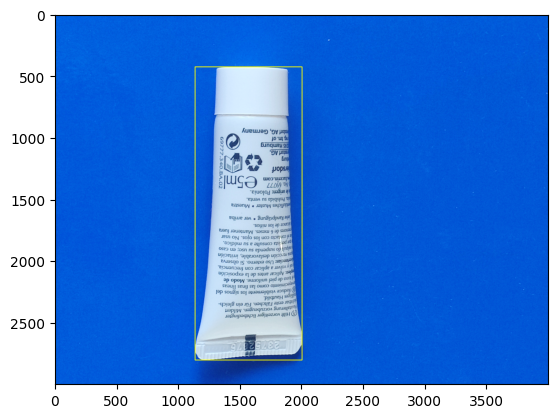

In [15]:
tp, TP, filtp, FILTP = Imp("Photos/Toothpaste/D4.jpg")

thresh_tp = cv2.threshold(filtp, 125, 255, cv2.THRESH_OTSU)[1]

plt.imshow(thresh_tp)
plt.show()
whitep = np.count_nonzero(thresh_tp)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh_tp, connectivity = 8, ltype = cv2.CV_32S)
max_area_index = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1 
max_area = stats[max_area_index, cv2.CC_STAT_AREA]
x = stats[max_area_index, cv2.CC_STAT_LEFT]
y = stats[max_area_index, cv2.CC_STAT_TOP]
width = stats[max_area_index, cv2.CC_STAT_WIDTH]
heigth = stats[max_area_index, cv2.CC_STAT_HEIGHT]
Pic = cv2.rectangle(FILTP, (stats[max_area_index, cv2.CC_STAT_LEFT], stats[max_area_index, cv2.CC_STAT_TOP]), (stats[max_area_index, cv2.CC_STAT_LEFT] +stats[max_area_index, cv2.CC_STAT_WIDTH], stats[max_area_index, cv2.CC_STAT_TOP] + stats[max_area_index, cv2.CC_STAT_HEIGHT]), (255, 255, 0), 5)

plt.imshow(Pic)
plt.show()

# Generalizing
Of course, under different circumstances can be made adjustmenst to this algorithm. A simple one, if there is notable light changing, we can increase the threshold value of the errors to cancel out differences in intensities due to light change. We can increase the size of the mask of the borders, make the external border unrelevant in the differences and so on.